In [1]:
import pandas  as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
np.random.seed(30)
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from collections import Counter
import keras
from keras.layers import Conv2D,Dense,Flatten
import keras.backend as K
from keras.callbacks import ModelCheckpoint
from keras.layers import Input
from keras.models import Model
from sklearn.model_selection import KFold


/home/rithwik/anaconda/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
days = pd.HDFStore('../Combined Datasets/daily.h5','r')
hours = pd.HDFStore('../Combined Datasets/hourly.h5','r')

In [3]:
train_prop = .65
v_prop = .2
test_prop = .15
keys = days.keys()

const = 1000.0

In [4]:
def return_data(keys,n_months):
    

    appliance1 = 'use'
    appliance2 = 'refrigerator1'
    
    

    
    X = np.array([days[i][appliance1].values for i in keys if (appliance1 in days[i].columns and appliance2 in days[i].columns )])[:,:28*n_months]/const
    y = np.array([hours[i][appliance2].values for i in keys if (appliance1 in hours[i].columns and appliance2 in hours[i].columns )])[:,:(28*24*n_months)]/const
    
    X = X.reshape((len(X)*n_months,4,7))
    X = np.expand_dims(X,axis=3)    
    
    
    
    y = y.reshape((len(y)*n_months,28*24))
    
    
    
    return X,y


def mae(truth,pred):
    return np.mean(const*np.abs((truth-pred)))

    
    
    

In [5]:
def network():
    
    input_layer = Input(shape=(4,7,1),name="Monthly_Matrix")
    input_layer_2 = Input(shape=(1,),name="Cooling_Degree_Day_Monthly")
    

    op1 = Conv2D(10,kernel_size=(4,1), strides=(1,1),name="Filter_4X1")(input_layer)
    
    op1 = Flatten()(op1)
    
    
    
    op2 = Conv2D(10,kernel_size=(1,7), strides=(1,1),name="Filter_1X7")(input_layer)
    
    op2 = Flatten()(op2)
    
    
    op3 = Conv2D(10,kernel_size=(1,2),strides=(1,1),name="Filter_1X2")(input_layer)
    
    op3 = Flatten()(op3)
    
    op4 = Conv2D(10,kernel_size=(2,1),strides=(1,1),name="Filter_2X1")(input_layer)
    
    op4 = Flatten()(op4)
    
    #op5 = Conv2D(20,kernel_size=(3,3),strides=(1,1),padding='same')(input_layer)
    
    #op5 = Conv2D(20,3,strides=(1,1),padding='same')(input_layer)
    
    #op5 = Flatten()(op5)
    
    #op5 =  keras.layers.Dropout(.2)(op5)
    
    #op5  = Dense(168*4)(op5)
    
    
    
    
    
    
    
    
    
    merge_layer = keras.layers.concatenate([op1, op2, op3,op4],name="Concatenation_1")
    

    
    merge_layer =  keras.layers.Dropout(.1)(merge_layer)
    
    
    
    merge_layer = keras.layers.concatenate(([merge_layer,input_layer_2]),name="Concatenation_2")
    
    final_layer = Dense(168*4,name="Output_Dense",activation='relu')(merge_layer)
    
    
    #final_layer = keras.layers.LeakyReLU(alpha=0.01)(final_layer)
    
    #predictions = Dense(1, activation='sigmoid')(merge_layer)

    
    
    
    model = Model(inputs=[input_layer,input_layer_2], outputs=final_layer)

    
    return model
    
    

In [6]:
def empty_dir(dir_name):
    for i in os.listdir(dir_name):
        os.remove(dir_name+"/"+i)

In [7]:
def fit_model(train_x,train_y,test_x,test_y,v_x,v_y):
    
    model = network()
    n_epochs = 3000
    sgd = keras.optimizers.SGD(lr=0.01)
    rmsprop  = keras.optimizers.RMSprop(lr=.001)
    adagrad = keras.optimizers.adagrad(lr=.001)
    model.compile(optimizer=rms, loss='mean_squared_error')
    
    dir_name = 'temp'
    empty_dir(dir_name)
    
    print("Started Training!")
    checkpoint = ModelCheckpoint(dir_name+'/single-model-{epoch:04d}.h5', verbose=0, monitor='val_loss',save_best_only=True, mode='auto')  
    model.fit([train_x,train_temp], train_y, epochs=n_epochs, validation_data=[[v_x,v_temp],v_y], callbacks=[checkpoint], verbose=0)

    all_files = os.listdir(dir_name)
    all_files.sort()
    weights_file = all_files[-1]
    
    
    model.load_weights(dir_name+"/"+weights_file)
    
    
    pred_train = model.predict([train_x,train_temp])
    pred_v = model.predict([v_x,v_temp])
    pred_test = model.predict([test_x,test_temp])
    
    train_cost = mae(train_y,pred_train)
    v_cost = mae(v_y,pred_v)
    test_cost = mae(test_y,pred_test)
    
    return train_cost,v_cost,test_cost
    
    
    
    
    
    
    

In [8]:
n_experiments = 1
results_arr = [] 
for exp in range(n_experiments):
    
    keys = days.keys()

    np.random.seed(exp)
    
    np.random.shuffle(keys)
    
    train_homes = keys[:int(len(keys)*train_prop)]
    test_homes = keys[int(len(keys)*train_prop):int(-len(keys)*v_prop)]
    val_homes = keys[int(-len(keys)*v_prop):]
    
    train_x,train_y = return_data(train_homes,3)
    
    test_x,test_y = return_data(test_homes,3)
    
    v_x,v_y  = return_data(val_homes,3)
    
    
    
    vals = [16,18,21]
    
    
    train_temp = np.array(vals*(len(train_x)/3))
    
    v_temp = np.array(vals*(len(v_x)/3))
    
    test_temp = np.array(vals*(len(test_x)/3))
    
    
    
    
    results = fit_model(train_x,train_y,test_x,test_y,v_x,v_y)
    
    print (results)
    
    results_arr.append(results)
    
    

Started Training!
(68.7766, 58.401237, 58.551765)


In [34]:
results_arr = np.array(results_arr)

In [35]:
np.mean(results_arr,axis=0)

array([66.588  , 64.53361, 59.96929], dtype=float32)

In [9]:
model = network()
model.load_weights("temp/single-model-2993.h5")

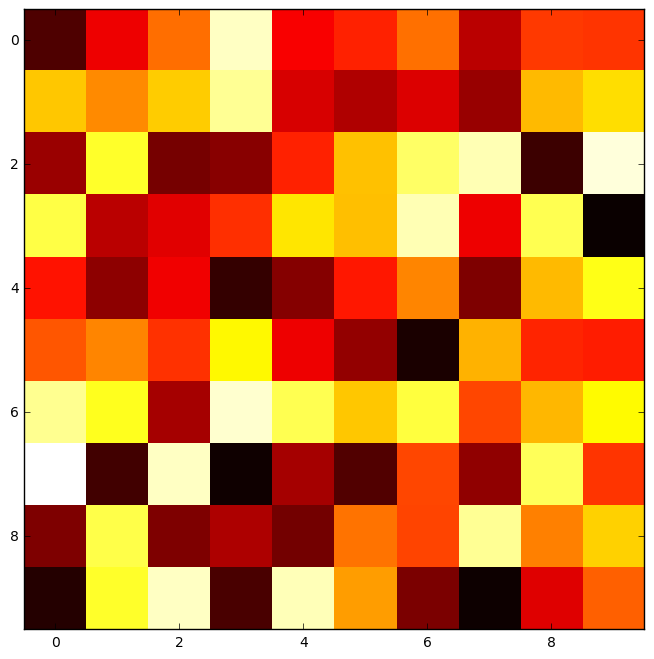

In [14]:
curr_weights = model.get_weights()[-2][:10,:10]
plt.figure(figsize=(20,8))
plt.imshow(curr_weights, cmap='hot',interpolation="nearest")
plt.show()

In [18]:
model.get_weights()[-2].mean(axis=1)

array([ 3.83394095e-03,  1.46737823e-03, -2.90514855e-03,  3.32105719e-03,
        2.74414849e-03, -1.14314619e-03,  9.63318918e-04,  6.11288473e-03,
        3.97483213e-03, -2.93906126e-03,  8.49817996e-04, -5.28455828e-04,
       -4.46704170e-03,  2.54163728e-03,  3.36640794e-03,  1.16100942e-03,
       -1.51820132e-03,  7.69579550e-03,  3.62480897e-03, -2.82363594e-03,
        5.84842358e-03, -2.89521035e-04, -2.46276642e-04,  2.32275762e-03,
        3.03169154e-03,  2.58422899e-03, -1.28645659e-03,  9.95486230e-03,
        4.95447032e-03, -1.36019161e-03,  1.92114024e-03,  3.62842518e-04,
       -4.55649849e-03,  2.63425754e-03,  5.98812196e-03,  9.83291306e-04,
       -5.58189968e-05,  6.62578363e-03,  4.07951651e-03, -2.23466079e-03,
        1.35957799e-03,  9.04145243e-04, -4.31042444e-03,  3.50427441e-03,
        5.28899441e-03,  2.28021434e-03,  1.22801517e-03,  7.37491343e-03,
        4.45116265e-03, -3.68961482e-03,  4.11376404e-03,  4.71589109e-03,
       -1.42026716e-03,  